# Week 3 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [47]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
import sklearn.feature_extraction
import sklearn.datasets

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [41]:
noise = .2

dfTrain1, dfTest1 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
dfTrain2, dfTest2 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
dfTrain3, dfTest3 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
dfTrain4, dfTest4 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
dfTrain5, dfTest5 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

noise2 = .4

dfTrain6, dfTest6 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise2))
dfTrain7, dfTest7 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise2)) #Please try this one
dfTrain8, dfTest8 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise2))
dfTrain9, dfTest9 = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise2))

We can easily visualize the rendered datasets because they are generated in two dimensions.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


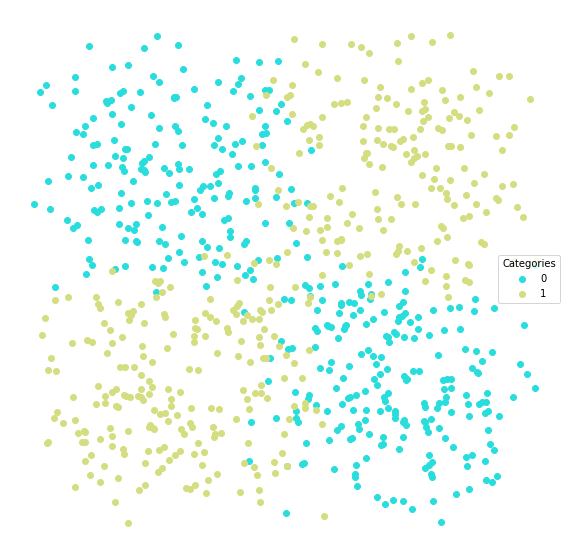

In [11]:
lucem_illud_2020.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [11]:
#Bayes
clf1 = sklearn.naive_bayes.GaussianNB()

#Analogizes
clf2 = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
clf3 = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf4 = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
clf5 = sklearn.linear_model.LogisticRegression()

#Symbolists
clf6 = sklearn.tree.DecisionTreeClassifier()
clf7 = sklearn.ensemble.RandomForestClassifier()

#Connectionists
clf8 = sklearn.neural_network.MLPClassifier()

#Ensemble
clf9 = sklearn.ensemble.GradientBoostingClassifier()
    
    

Now we fit the model by giving it our training data

In [8]:
def fit_model_df_evaluate(model, df_train, df_test):
    model.fit(np.stack(df_train['vect'], axis=0), df_train['category'])
    print(lucem_illud_2020.evaluateClassifier(model, df_test))
    #lucem_illud_2020.plotConfusionMatrix(model, df_test)
    #lucem_illud_2020.plotMultiROC(model, df_test)
    #lucem_illud_2020.plotregions(model, df_train)

In [9]:
def try_every_model(df_train, df_test):
    print("model 1")
    fit_model_df_evaluate(clf1, df_train, df_test)
    
    print("model 2")
    fit_model_df_evaluate(clf2, df_train, df_test)
    
    print("model 3")
    fit_model_df_evaluate(clf3, df_train, df_test)

    print("model 4")
    fit_model_df_evaluate(clf4, df_train, df_test)
    
    print("model 5")
    fit_model_df_evaluate(clf5, df_train, df_test)
   
    print("model 6")
    fit_model_df_evaluate(clf6, df_train, df_test)
    
    print("model 7")
    fit_model_df_evaluate(clf7, df_train, df_test)
    
    print("model 8")
    fit_model_df_evaluate(clf8, df_train, df_test)

    print("model 9")
    fit_model_df_evaluate(clf9, df_train, df_test)

## Exercise 1 Part 1:


df 1: Model 7 and 9 does best, but all have about a 50% accuarcy and recall. This makes sense, because the classifiers are assigned randomly, so the models also predict randomly, and thus have about a 50% accuracy. 

df 2: All models do very well, with the Random Forest ensemble doing the best. This also makes sense, because these classifiers are based on one feature, making it easy for any model to predict a classifier correctly.

df 3: In this case the gradient booster model does this best, with a high precision, recall and low error rate. This makes sense, because the classifier was assigned by splitting on both features. Therefore any simple linear separator would do poorly. The gradient booster uses multiple decision trees, so can separate classifiers by both features. This is why the prediction does best. 

df 4: In this case the naive bayes classifier does best, with random forests and neural nets closely following. In this case the classifer is not separated linearly, instead it is separated  

df 5: In this case all models do farily well, with precision and recall around 90%. In this case 5 categorical labels are assigned randomly in 5 groups, so a 50-50 chance means an error rate of about 10%, which is consist across models.
    
df 6: This is also split along one feature, but with double the noise than df 2. In this case all the models do okay, and have a similar AUC, precision and accuracy, but the ensemble Gradient Booster does slightly better than the rest.

df 7: In this case, the ensemble gradient booster does the best, with the random forest ensemble a close second. This is the same as with dataframe 3, which used the same splitting technique but with less noise. This classifier makes sense because the classifer is assigned based on two features, so the models that can take both into account to best.

df 8: Nueral networks do best here. This makes sense, because the classifications were assigned nested within two features. This makes it difficutlt for a machine to predict the labels with a linear model, so models that are non-linear do better. 

df 9: All the models did pretty well/equally well in this case. Again this makes sense because the labels were assigned randomly, so there is no way to predict the labels better than 50-50. This is the same as with dataframe 5. The increased noise doesn't impact the error rate.

df 10: This is the randomly assigned label across the whole dataframe. Increasing the noise on this dataframe doesn't change the dataframe, so the results are similar to dataframe 1, where all the models are pretty equal in predicting classifiers.


In [99]:
try_every_model(dfTrain1, dfTest1)

model 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.53  0.492248   0.558824           0.566275  0.333333
1               0.53  0.492248   0.424242           0.426251  0.651163
model 2
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0               0.57  0.5       0.00               0.57     0.0
1               0.57  0.5       0.43               0.43     1.0
model 3
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0               0.57  0.5       0.00               0.57     0.0
1               0.57  0.5       0.43               0.43     1.0
model 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.47  0.533456

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.53  0.495104   0.562500           0.567632  0.315789
1               0.53  0.495104   0.426471           0.427620  0.674419
model 9
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.475  0.534782   0.609195           0.588222  0.464912
1              0.475  0.534782   0.460177           0.448247  0.604651


In [98]:
try_every_model(dfTrain2, dfTest2)

model 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.115  0.885464   0.901961           0.855289  0.876190
1              0.115  0.885464   0.867347           0.826047  0.894737
model 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.115  0.884962   0.894231           0.852033  0.885714
1              0.115  0.884962   0.875000           0.828684  0.884211
model 3
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.125  0.879449   0.965116           0.872901  0.790476
1              0.125  0.879449   0.807018           0.796533  0.968421
model 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                     

In [97]:
try_every_model(dfTrain3, dfTest3)

model 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.575  0.427193   0.375000           0.477970  0.207921
1              0.575  0.427193   0.444444           0.462318  0.646465
model 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.485  0.516102   0.525641           0.513379  0.405941
1              0.485  0.516102   0.508197           0.503265  0.626263
model 3
          Error_Rate      AUC  Precision  Average_Precision   Recall
Category                                                            
0              0.305  0.69702   0.833333           0.667541  0.49505
1              0.305  0.69702   0.635714           0.621501  0.89899
model 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                             

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [100]:
try_every_model(dfTrain4, dfTest4)

model 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.095  0.906263   0.855856           0.844656  0.969388
1              0.095  0.906263   0.966292           0.894717  0.843137
model 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.34  0.665266   0.598684           0.590921  0.928571
1               0.34  0.665266   0.854167           0.648342  0.401961
model 3
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0               0.51  0.5       0.49               0.49     1.0
1               0.51  0.5       0.00               0.51     0.0
model 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0                0.1  0.90096   0.861111           0.842177  0.948980
1                0.1  0.90096   0.945652           0.881586  0.852941
model 9
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.12  0.880552   0.855769           0.822178  0.908163
1               0.12  0.880552   0.906250           0.847978  0.852941


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [101]:
try_every_model(dfTrain5, dfTest5)

model 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.010  0.980536   0.990654           0.962630  0.963636
1              0.002  0.995455   1.000000           0.992909  0.990909
2              0.072  0.889287   0.776596           0.674221  0.829545
3              0.010  0.989516   0.956522           0.947774  0.988764
4              0.070  0.884021   0.846939           0.722485  0.805825
model 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.010  0.980536   0.990654           0.962630  0.963636
1              0.002  0.995455   1.000000           0.992909  0.990909
2              0.066  0.897396   0.795699           0.697110  0.840909
3              0.010  0.989516   0.956522           0.947774  0.988764
4              0.064  0.894989   0.858586           0.744542 

In [102]:
try_every_model(dfTrain6, dfTest6)

model 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.25  0.747475   0.722222           0.646605  0.722222
1               0.25  0.747475   0.772727           0.722107  0.772727
model 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.24  0.756566   0.738636           0.658460  0.722222
1               0.24  0.756566   0.776786           0.729367  0.790909
model 3
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.23  0.763636   0.768293           0.672805  0.700000
1               0.23  0.763636   0.771186           0.732982  0.827273
model 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                     

In [103]:
try_every_model(dfTrain7, dfTest7)

model 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.49  0.511218   0.531915           0.525728  0.480769
1               0.49  0.511218   0.490566           0.485723  0.541667
model 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.48  0.525641   0.555556           0.533675  0.384615
1               0.48  0.525641   0.500000           0.493333  0.666667
model 3
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.23  0.776843   0.926471           0.766227  0.605769
1               0.23  0.776843   0.689394           0.678488  0.947917
model 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                     

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [104]:
try_every_model(dfTrain8, dfTest8)

model 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.23  0.769296   0.840708           0.789327  0.772358
1               0.23  0.769296   0.678161           0.609630  0.766234
model 2
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.615  0.5      0.000              0.615     0.0
1              0.615  0.5      0.385              0.385     1.0
model 3
          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
0              0.615  0.5      0.000              0.615     0.0
1              0.615  0.5      0.385              0.385     1.0
model 4
          Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0               0.28  0.72136   

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.235  0.767659   0.845455           0.789246  0.756098
1              0.235  0.767659   0.666667           0.604481  0.779221
model 9
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.245  0.757101   0.836364           0.780573  0.747967
1              0.245  0.757101   0.655556           0.592309  0.766234


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [105]:
try_every_model(dfTrain9, dfTest9)

model 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.064  0.900271   0.808511           0.710742  0.844444
1              0.064  0.893347   0.855670           0.739174  0.821782
2              0.006  0.996000   0.976562           0.976562  1.000000
3              0.040  0.941816   0.875000           0.814913  0.913043
4              0.046  0.908674   0.905882           0.788184  0.836957
model 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.068  0.893496   0.797872           0.694894  0.833333
1              0.068  0.887144   0.845361           0.724333  0.811881
2              0.008  0.994667   0.968992           0.968992  1.000000
3              0.042  0.932172   0.881720           0.805881  0.891304
4              0.050  0.906223   0.885057           0.770755 

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [6]:
dfTrain_red, dfTest_red = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
dfTrain_news, dfTest_news = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
dfTrain_sensm, dfTest_sensm = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
dfTrain_senl, dfTest_senl = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
dfTrain_spam, dfTest_spam = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Reddit data
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading senate data
Converting to vectors
Loading senator: Klobuchar
Loading senator: Kyl
Loading senator: Kerry
Loading senator: Kohl
Loading senator: Kennedy
Converting to vectors
Loading Spam
Loading Ham
Converting to vectors


In [12]:
try_every_model(dfTrain_red, dfTest_red)

model 1
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Relationships              0.228840  0.637931   0.652174           0.403571   
Bad Roommates              0.181818  0.729489   0.588235           0.430178   
Weeaboo Tales              0.197492  0.858090   0.527559           0.514354   
Tales From Tech Support    0.075235  0.885726   0.935897           0.802175   

                           Recall  
Category                           
Relationships            0.344828  
Bad Roommates            0.571429  
Weeaboo Tales            0.957143  
Tales From Tech Support  0.793478  
model 2
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Relationships              0.028213  0.959052   0.964286           0.916592   
Bad Roommates              0.025078  0.973666   0.918919

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                         Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                                      
Relationships              0.272727  0.5   0.000000           0.272727     0.0
Bad Roommates              0.219436  0.5   0.000000           0.219436     0.0
Weeaboo Tales              0.780564  0.5   0.219436           0.219436     1.0
Tales From Tech Support    0.288401  0.5   0.000000           0.288401     0.0
model 4
                         Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Relationships              0.087774  0.871408   0.883117           0.749813   
Bad Roommates              0.062696  0.944435   0.797619           0.772840   
Weeaboo Tales              0.040752  0.932817   0.925373           0.844695   
Tales From Tech Support    0.034483  0.956378   0.945055           0.902230   

                           Recall  
Categor

In [13]:
try_every_model(dfTrain_news, dfTest_news)

model 1
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
rec.autos                0.095745  0.854543   0.858491           0.709471   
comp.windows.x           0.072340  0.899405   0.870690           0.773256   
comp.sys.mac.hardware    0.151064  0.814685   0.712121           0.597295   
misc.forsale             0.119149  0.849504   0.698276           0.599194   

                         Recall  
Category                         
rec.autos              0.752066  
comp.windows.x         0.841667  
comp.sys.mac.hardware  0.740157  
misc.forsale           0.794118  
model 2
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
rec.autos                0.059574  0.938289   0.849624           0.810472   
comp.windows.x           0.034043  0.947024   0.956140           0.891898   
comp.sys.

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                       Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                                    
rec.autos                0.257447  0.5   0.000000           0.257447     0.0
comp.windows.x           0.255319  0.5   0.000000           0.255319     0.0
comp.sys.mac.hardware    0.270213  0.5   0.000000           0.270213     0.0
misc.forsale             0.782979  0.5   0.217021           0.217021     1.0
model 4
                       Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
rec.autos                0.342553  0.577672   0.357143           0.298644   
comp.windows.x           0.248936  0.567262   0.534884           0.308902   
comp.sys.mac.hardware    0.480851  0.544111   0.302789           0.289707   
misc.forsale             0.208511  0.576300   0.555556           0.283401   

                         Recall  
Category                         

In [14]:
try_every_model(dfTrain_sensm, dfTest_sensm)

model 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.143695  0.854501   0.893939           0.853952  0.863415
Obama       0.143695  0.854501   0.804196           0.741602  0.845588
model 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.014663  0.982855   0.980769           0.978918  0.995122
Obama       0.014663  0.982855   0.992481           0.975021  0.970588
model 3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
Clinton     0.398827  0.5   0.601173           0.601173     1.0
Obama       0.398827  0.5   0.000000           0.398827     0.0
model 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton     0.134897  0.861819   0.895522           0.859626  0.878049
Obama       0.134897  0.861819   0.821429           0.756174  0.845588
model 5
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton      0.02346  0.970588   0.962441           0.962441  1.000000
Obama        0.02346  0.970588   1.000000           0.964637  0.941176
model 6
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
Clinton   

In [15]:
try_every_model(dfTrain_senl, dfTest_senl)

model 1
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Kennedy      0.246154  0.762637   0.676000           0.659353  0.918478
Kohl         0.044872  0.732478   0.935484           0.479873  0.467742
Kerry        0.157692  0.761389   0.674847           0.502150  0.611111
Kyl          0.070513  0.728126   0.957447           0.507593  0.459184
Klobuchar    0.057692  0.724929   0.846154           0.437821  0.458333
model 2
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Kennedy      0.029487  0.971217   0.955145           0.947264  0.983696
Kohl         0.002564  0.983871   1.000000           0.970306  0.967742
Kerry        0.017949  0.974722   0.961111           0.932709  0.961111
Kyl          0.003846  0.984694   1.000000           0.973234  0.969388
Klobuchar    0.007692  0.958333   1.000000      

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


           Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                        
Kennedy      0.528205  0.5   0.471795           0.471795     1.0
Kohl         0.079487  0.5   0.000000           0.079487     0.0
Kerry        0.230769  0.5   0.000000           0.230769     0.0
Kyl          0.125641  0.5   0.000000           0.125641     0.0
Klobuchar    0.092308  0.5   0.000000           0.092308     0.0
model 4
           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                               
Kennedy      0.175641  0.829675   0.757238           0.735520  0.923913
Kohl         0.038462  0.817010   0.833333           0.565840  0.645161
Kerry        0.134615  0.791944   0.732919           0.559956  0.655556
Kyl          0.055128  0.806826   0.910448           0.614143  0.622449
Klobuchar    0.039744  0.828390   0.872727           0.612587  0.666667
model 5
           Error_Rate    

In [16]:
try_every_model(dfTrain_spam, dfTest_spam)

model 1
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
spam        0.171053  0.800377   0.449704           0.376863  0.760000
not spam    0.171053  0.800377   0.953398           0.937538  0.840753
model 2
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
spam        0.093567  0.713151   0.846154           0.454179  0.440000
not spam    0.093567  0.713151   0.911392           0.910603  0.986301
model 3


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          Error_Rate  AUC  Precision  Average_Precision  Recall
Category                                                       
spam        0.146199  0.5   0.000000           0.146199     0.0
not spam    0.146199  0.5   0.853801           0.853801     1.0
model 4
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
spam        0.093567  0.721438   0.821429           0.456805  0.460000
not spam    0.093567  0.721438   0.914013           0.912982  0.982877
model 5
          Error_Rate   AUC  Precision  Average_Precision  Recall
Category                                                        
spam        0.114035  0.61   1.000000           0.334035    0.22
not spam    0.114035  0.61   0.882175           0.882175    1.00
model 6
          Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
spam        0.068713  0.823014   0

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

## EXERCISE 1 ANSWERS

## COME BACK HERE AND FINISH WRITING ANSWERS TO THE ABOVE.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.

Note: Because my hand labeled dataset is too small, I am using a dataset from Kaggle. It contains 3000 tweets from hillary clinton and trump before the 2016 presidential election. 

### Summary of Results shown below:

The logistic regression with l1 penalty does slightly better than the naive bayes classifier on every score. As the confusion matrix shows, the logistic regression has more true positives and true negatives marginally than the naive bayes, and fewer false positives and false negatives. 

The accuracy for the logistic regression with L1 regularization does the better than any of the logistic regressions on the reduced dimension (PCA) matrix. The L1 regularization is also a way of reducing dimensions, it's a lasso regression that picks the most important features and reduces the rest to have a 0 coefficient. In this case the lasso does better than the PCA.

### Summary of Exercise 2 Analysis
(I ran this after doing the whole section)

In [129]:
lucem_illud_2020.evaluateClassifier(logistic_l1, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.127329,0.872375,0.883987,0.826522,0.853312
True,0.127329,0.872375,0.862426,0.823923,0.891437


In [130]:
lucem_illud_2020.evaluateClassifier(naiveBayes, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.13354,0.86621,0.875000,0.817646,0.850158
True,0.13354,0.86621,0.858631,0.817321,0.882263


### Full Exercise 2 Method

In [114]:
tweets = pandas.read_csv("tweets.csv")

In [72]:
tweets['category'] = [s == 'HillaryClinton' for s in tweets['handle']]

Tokenize and normalize

In [74]:
tweets['tokenized_text'] = tweets['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
tweets['normalized_text'] = tweets['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

split the data into training data and testing data.

In [76]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(tweets, holdBackFraction=holdBackFraction)

In [77]:
print(len(train_data_df))
print(len(test_data_df))

5156
1288


## Logistic Regression

Turn the training dataset into a tf-idf matrix

In [78]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

In [80]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

#### PCA

In [81]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [82]:
train_data_df['pca'] = [r for r in reduced_data]

In [85]:
len(train_data_df)

5156

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


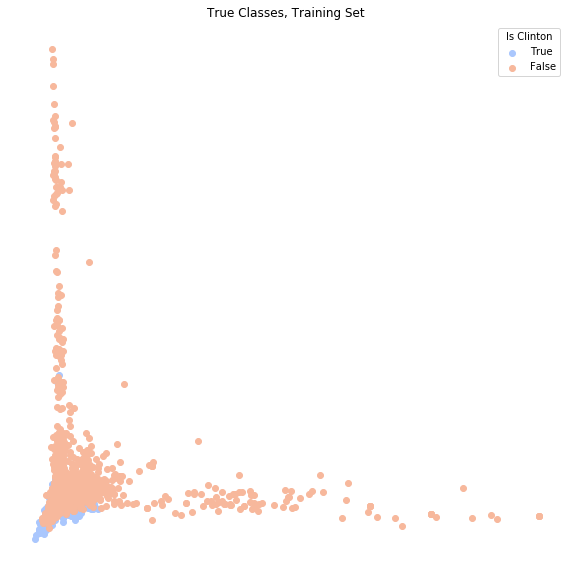

In [83]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Clinton
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Clinton
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Clinton')
plt.title('True Classes, Training Set')
plt.show()

choose the first 10 pricipal components as our covariates.

In [86]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [87]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [88]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.7668735453840186

Do on testing dataset

In [89]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.7593167701863354

In [90]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.806245151280062
Testing:
0.7942546583850931


Try with 100 features

In [91]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8281613653995346
Testing:
0.8136645962732919


Try with (200)

In [92]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8446470131885182
Testing:
0.8229813664596274


Use a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [94]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9354150504266874


Train the model using training data, and then test it on the testing data.

In [95]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8726708074534162


#### Other logistic measures

In [117]:
test_data_df['l1_predict'] = logistic_l1.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['l1_predict_prob_true'] = logistic_l1.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision

In [119]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['l1_predict'])

0.8624260355029586

Recall

In [120]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['l1_predict'])

0.8914373088685015

F1 Measure

In [121]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['l1_predict'])

0.8766917293233082

Confusion matrix

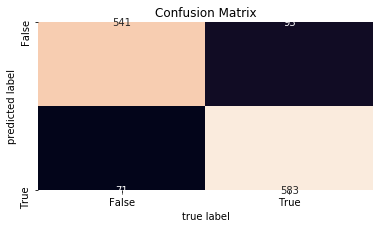

In [125]:
lucem_illud_2020.plotConfusionMatrix(logistic_l1, test_data_df)

In [128]:
lucem_illud_2020.evaluateClassifier(logistic_l1, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.127329,0.872375,0.883987,0.826522,0.853312
True,0.127329,0.872375,0.862426,0.823923,0.891437


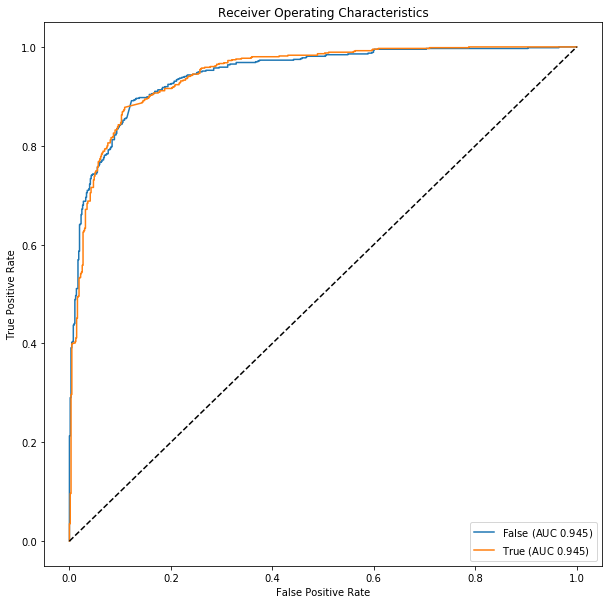

In [126]:
lucem_illud_2020.plotMultiROC(logistic_l1, test_data_df)

## Naive Bayes

In [96]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [97]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9272692009309542
Testing:
0.8664596273291926


In [98]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [99]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.8586309523809523

Recall:

In [100]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.882262996941896

F1-measure:

In [101]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8702865761689291

Confusion Matrix

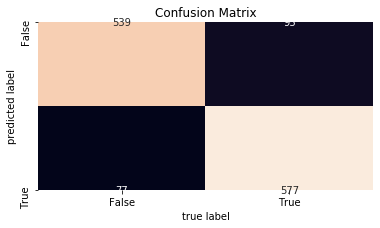

In [127]:
lucem_illud_2020.plotConfusionMatrix(naiveBayes, test_data_df)

Compare posterior distribution looks relative to the truth.

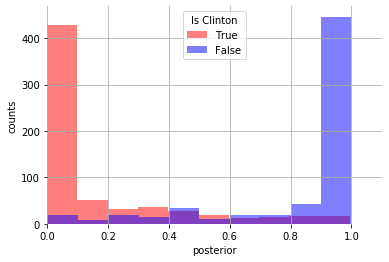

In [122]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Clinton")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

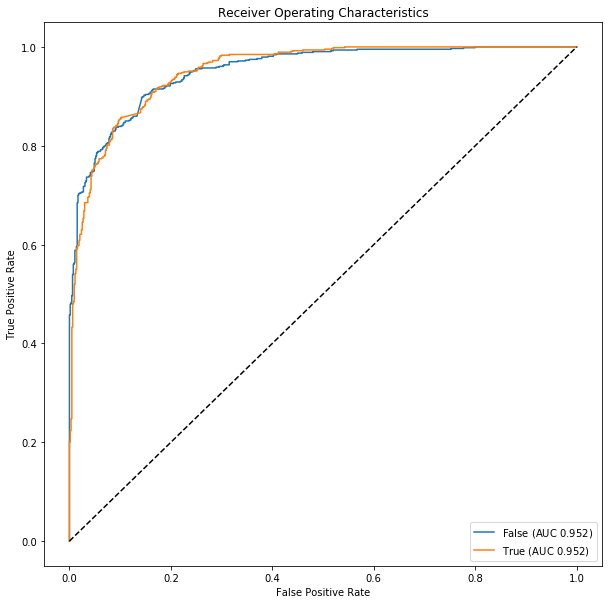

In [154]:
lucem_illud_2020.plotMultiROC(naiveBayes, test_data_df)

### Change this - what does this tell us?
The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [116]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Trump' : [],
    'Trump_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Trump'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Trump_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Trump,Trump_log_prob,Clinton,Clinton_log_prob
0,cnn,-3.369231,ve,-3.387308
1,poll,-3.540379,hillaryclinton,-3.549151
2,bad,-3.553802,plan,-3.663562
3,enjoy,-3.553802,work,-3.678829
4,foxnews,-3.581201,know,-3.710082
5,media,-3.623761,tax,-3.758872
6,rubio,-3.623761,timkaine,-3.792773
7,amazing,-3.698984,live,-3.810165
8,tomorrow,-3.698984,right,-3.810165
9,win,-3.714733,got,-3.827865


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

I will use the tweets dataset above.

### Summary: 

Both decision trees and random forests performed quite poorly. Both models had particularly high false negatives, so the model labeled a Clinton tweet as a Trump tweet instead. This may be due to the use of handle names in each of their tweets. Decision trees effectively only pick the most important 10 features, so the ambigious use of handle tweets could result in poor classifiers. 

A random forest is essentially putting together many random shallow decision trees. With the vast amount of words used, a poor shallow decision trees in this case, using a randome forest doesn't result in a better classifier - which is reflected in the scores. Ensemble learning generally puts together various classifiers to enhance predicitions.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


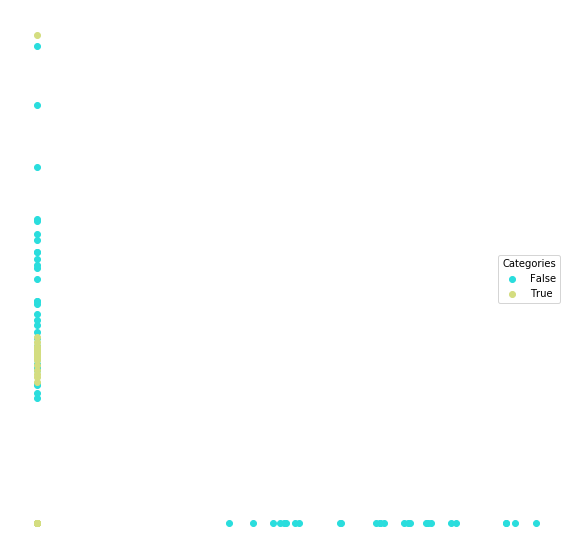

In [145]:
lucem_illud_2020.plotter(train_data_df)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [147]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=10,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

To see what's going on visually with the classification: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


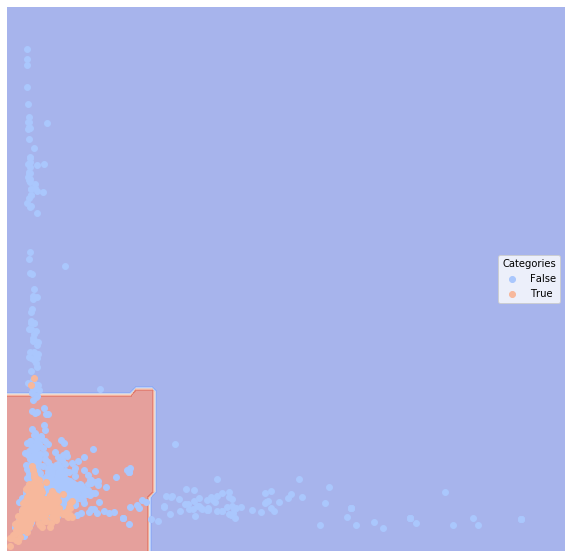

In [148]:
lucem_illud_2020.plotregions(clf_tree, train_data_df)

In [149]:
lucem_illud_2020.evaluateClassifier(clf_tree, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.390225,0.61067,0.979866,0.609353,0.226006
True,0.390225,0.61067,0.561404,0.561112,0.995334


Lets look at accuracy:

In [150]:
sklearn.metrics.accuracy_score(train_data_df['category'],clf_tree.predict(np.stack(train_data_df['vect'], axis = 0)))

0.6097750193948798

What happens if we trim the tree?

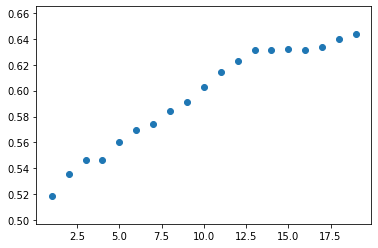

In [151]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(test_data_df['category'], tree2.predict(np.stack(test_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

This chart suggests that a decision tree with about 10 branches will do well without overfitting the data. 

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [152]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [153]:
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
      

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


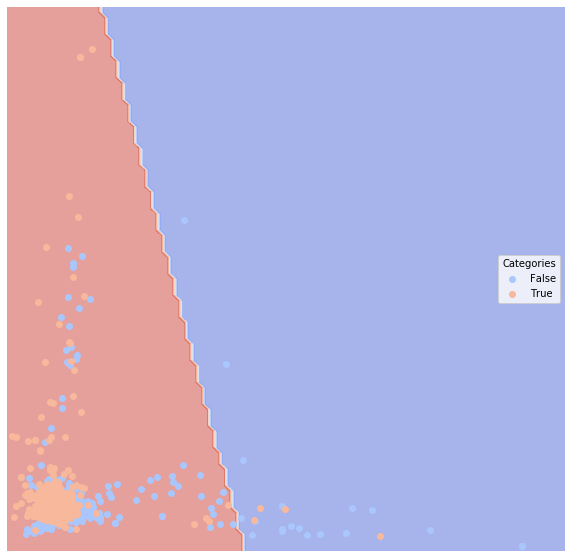

In [155]:
lucem_illud_2020.plotregions(bag, test_data_df)

In [156]:
lucem_illud_2020.evaluateClassifier(bag, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.350932,0.643774,0.950495,0.631015,0.302839
True,0.350932,0.643774,0.593002,0.591699,0.984709


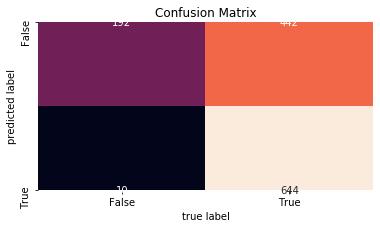

In [157]:
lucem_illud_2020.plotConfusionMatrix(bag, test_data_df)

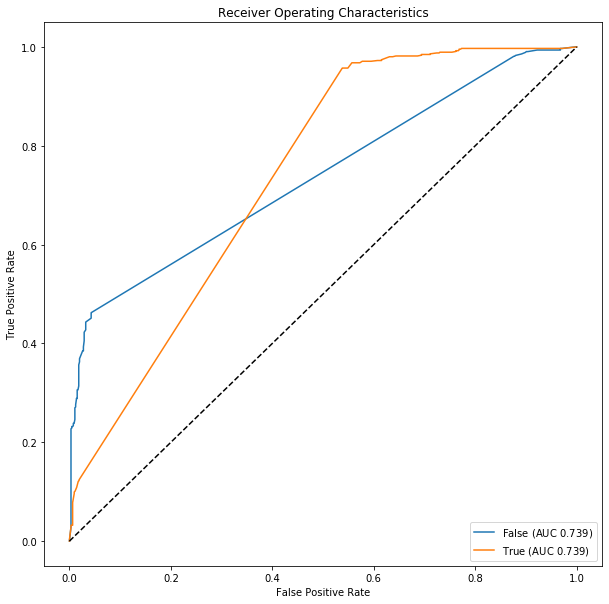

In [158]:
lucem_illud_2020.plotMultiROC(bag, test_data_df)

# K-Nearest Neighbors

Let's initialize our k-nearest neighbors classifier:

In [160]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [161]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_data_df['text'])
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [162]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [163]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
False,0.49069,0.508165,0.50528,0.50528,1.00000
True,0.49069,0.508165,1.00000,0.50702,0.01633


And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_data_df['k_predict'] = clf_knearest.predict(np.stack(test_data_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Testing score:


Let's produce another confusion matrix:

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

In [ ]:
lucem_illud_2020.plotMultiROC(clf_knearest, test_data_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?